# Set up

### Imports

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import librosa
import matplotlib.pyplot as plt    
import numpy as np
import pandas as pd 

#import librosa.display
#import matplotlib   
#import IPython.display as ipd
#from scipy.io import wavfile

from scipy import signal
from scipy.stats import norm, kurtosis
from scipy.signal import welch
from scipy.integrate import simps

#import scipy 

import operator #Used to sort 
import glob #
import json
from datetime import datetime

##import warnings
##warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


In [4]:
df_paths = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/wav_paths_master.csv") 

df_paths

,path,leak_type,environment,recording,mic,knob_rotations,leak_present
0,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,hydr,1,3l,6.5n,1
1,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,hydr,1,3m,8.5n,1
2,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,hydr,1,4m,5.0n,0
3,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,hydr,1,4l,4.5n,0
4,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,hydr,1,4l,7.5n,1
...,...,...,...,...,...,...,...
5587,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,tubeleak,hydr,3,3l,3.5n,0
5588,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,tubeleak,hydr,3,2m,1.0n,0
5589,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,tubeleak,hydr,3,4l,7.0n,1
5590,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,tubeleak,hydr,3,4l,8.0n,1


# Functions

## Helper functions 

In [5]:
def join_meta(df_meta, df_input):
  df = df_input.join(df_meta)
  df.index.name = "index"
  return df

In [6]:
from scipy.signal import butter, lfilter, filtfilt, sosfilt

def butter_highpass(cutoff, fs, order=9):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=9):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [7]:
def pre_save_files(df_input, cutoff=0, save_path=None, sr=None):
  df_files = pd.DataFrame()
  
  for ind in tqdm(df_input.index):
    y, sample_rate = librosa.load(df_input['path'][ind], sr=None)
    if type(cutoff) == int and cutoff > 0: 
      y = butter_highpass_filter(y, cutoff, sample_rate,order=4)
    df_file = pd.DataFrame({"samples": [y], "sr": sample_rate})
    df_files = pd.concat([df_files, df_file], join = 'outer', axis = 0)
  df_files.index = df_input.index
  
  if save_path:
    df_files.to_json(save_path)


  return df_files



In [8]:
def preprocesses(X,T,normalize=True):
  if normalize:
    scaler = MinMaxScaler()
    scaler = scaler.fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X))
    X_scaled.columns = X.columns
    T_scaled = pd.DataFrame(scaler.transform(T))
    T_scaled.columns = T.columns

  return X_scaled, T_scaled 


In [9]:
def make_list(split_list): #[0,10000,1000]
  split = split_list.copy()
  split[1] = split[1]+split[-1]
  splitted_list =  np.arange(split[0], split[1], split[2]).tolist()
  return splitted_list

In [10]:
def invert_preds(preds):
  return np.abs(preds-1)

def get_accuracy(pred, gt):
  score = 0 
  if len(pred) != len(gt):
    return
  for i in range(len(pred)):
    if pred[i] == gt[i]:
      score+=1

  accuracy = np.round(score/len(pred),4)

  if accuracy < 0.1:
    accuracy=1-accuracy

  return accuracy

In [11]:
def get_wanted_files(df, wanted_files):
    for key in wanted_files:
        if wanted_files[key]:
            df = df.loc[(df[key].isin(wanted_files[key]))]
    return df 


In [12]:
def bandpower(data, sf, band_list, window_sec=None, relative=False, reduce_split=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """


    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = 0.3 * sf

    # Compute the modified periodogram (Welch)
    #win = scipy.signal.get_window('hanning',nperseg)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    
    avg_band_power = []

    #Kan vurdere å bruke matplotlib sin psd 
    ##win = matplotlib.mlab.window_hanning(np.ones(nperseg)) # or
    ##psd, freqs = matplotlib.mlab.psd(data, Fs=sf,window=win)



    # Frequency resolution
    for i in range(len(band_list)-1):
      freq_res = freqs[1] - freqs[0]
      low = band_list[i]
      high = band_list[i+1]

      # Find closest indices of band in frequency vector
      idx_band = np.logical_and(freqs >= low, freqs <= high)

      # Integral approximation of the spectrum using Simpson's rule.
      bp = simps(psd[idx_band], dx=freq_res)


      if relative:
          bp /= simps(psd, dx=freq_res)

      
      avg_band_power.append(bp)


    if reduce_split:
      reduced = []  
      for i in range(len(reduce_split)-1):
        s = avg_band_power[reduce_split[i]:reduce_split[i+1]]
        reduced.append(sum(s))
      return pd.DataFrame([reduced])

    return pd.DataFrame([avg_band_power])

In [13]:
def plot_learning_curve(estimator, title, X, y,cv=None, n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 5),):
  plt.figure(figsize=(8,5))
  train_sizes, train_scores, test_scores = learning_curve(estimator,X,y)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",)
  plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")


  plt.fill_between(
      train_sizes,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.1,
      color="g",)
  plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

  plt.legend(loc="best")
  plt.title(title)
  plt.show()

In [14]:
def plot_corr_matrix(df_features):
  # run correlation matrix and plot
  f, ax = plt.subplots(figsize=(10, 8))
  corr = df_features.corr()
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
              cmap=sns.diverging_palette(220, 10, as_cmap=True),
              square=True, ax=ax)

## Feature functions

In [15]:
#Kan hende denne kan slettes? 
def get_bandpower_dataframe(df_input,window_sec, split_list, reduce_split=False):
  df = pd.DataFrame()

  band_list = make_list(split_list)
  
  for ind in tqdm(df_input.index):
    signal, sr = np.array(df_input["samples"][ind]), df_input["sr"][ind]
    bin_power = bandpower(signal, sr, band_list ,window_sec=window_sec, relative=True, reduce_split=reduce_split)
    df = pd.concat([df,bin_power],axis=0,ignore_index=True)
  
  df.index = df_input.index
  names = [str("rp_bin: " + str(i)) for i in range(len(np.array(df.columns)))]
  df.columns = names

  return df

"""
Split_list is what frequency segements the file should be devidied into, while reduce split combines several segments by summing between the elements in the list
A unneccesery way of doing it but I like that I still can get the firste version without reduced split
"""
#df_rel_pwr_train = get_bandpower_dataframe(df_train.head(), window_sec=10, split_list=[0, 24000, 1000])
#df_rel_pwr_train = get_bandpower_dataframe(df_train.head(), window_sec=10, split_list=[0, 24000, 1000], reduce_split=[0,6,13,-1])
#df_rel_pwr_train


'\nSplit_list is what frequency segements the file should be devidied into, while reduce split combines several segments by summing between the elements in the list\nA unneccesery way of doing it but I like that I still can get the firste version without reduced split\n'

In [16]:
def get_data_labels(df_train_features, df_test_features, drop_features=None):

  df_train_features_drop = df_train_features.drop(columns=['feature_index', 'index','samples','sr','path','leak_type','knob_rotations','environment','recording','mic'],errors='ignore')
  df_test_features_drop = df_test_features.drop(columns=['feature_index','index','samples','sr','path','leak_type','knob_rotations','environment','recording','mic'],errors='ignore')


  y = df_train_features_drop['leak_present'].values
  X = df_train_features_drop.drop(columns=['leak_present'])
  if drop_features: 
    X = X.drop(columns=drop_features)

  gt = df_test_features_drop['leak_present'].values
  T = df_test_features_drop.drop(columns=['leak_present'])
  if drop_features: 
    T = T.drop(columns=drop_features)



  return X,y,T,gt


## Feature Extraction

In [17]:
def get_train_test_dataframes_presaved(df, train_files, test_files, verbose):    
    df_train = get_wanted_files(df, train_files)
    df_test = get_wanted_files(df, test_files)

    if verbose: 
        print(str(np.round(df_train["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_train["leak_present"].value_counts())
        print(str(np.round(df_test["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_test["leak_present"].value_counts())
        
    return df_train, df_test


In [18]:
def get_train_test_dataframes(df, train_files, test_files, cutoff=0, verbose=0):    
    df_train = get_wanted_files(df, train_files)
    df_test = get_wanted_files(df, test_files)

    df_train_loaded = pre_save_files(df_train, cutoff=cutoff)
    df_test_loaded = pre_save_files(df_test, cutoff=cutoff)

    df_train = join_meta(df_train_loaded, df_train)
    df_test = join_meta(df_test_loaded, df_test)

    if verbose: 
        print(str(np.round(df_train["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_train["leak_present"].value_counts())
        print(str(np.round(df_test["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_test["leak_present"].value_counts())
        
    return df_train, df_test



In [19]:
def get_train_test_features(df_train, df_test, use_features, split_list, win_len, log_rel_pwr, shuffle):

  print("> making train features")
  df_train_features = get_all_features(df_train, use_features, split_list, win_len,log_rel_pwr=False) 
  df_train_features = df_train_features.loc[:, ~df_train_features.columns.duplicated()]
  df_train_features = df_train_features.join(df_train, on="feature_index", how="left")
  print("")

  
  print("> making test features")
  df_test_features = get_all_features(df_test,use_features, split_list, win_len,log_rel_pwr=False) 
  df_test_features = df_test_features.loc[:, ~df_test_features.columns.duplicated()]
  df_test_features = df_test_features.join(df_test, on="feature_index",how="left")
  print("")




  if log_rel_pwr:
    #x_norm, t_norm = preprocesses(df_train_features.filter(regex='rp_bin'), df_test_features.filter(regex='rp_bin'))
    x_norm, t_norm = df_train_features.filter(regex='rp_bin'), df_test_features.filter(regex='rp_bin')

    x_norm_log = np.log(x_norm) #Can test log10, log2 as well
    t_norm_log = np.log(t_norm)    
    df_train_features.loc[x_norm_log.index.isin(df_train_features.index), x_norm_log.columns.values] = x_norm_log[x_norm_log.columns.values]
    df_test_features.loc[t_norm_log.index.isin(df_test_features.index), t_norm_log.columns.values] = t_norm_log[t_norm_log.columns.values]

  if shuffle: 
    df_train_features = shuffle(df_train_features)
    df_test_features = shuffle(df_test_features)


  return df_train_features, df_test_features


In [20]:
def get_all_features(df, use_features, split_list, win_len=0.3, log_rel_pwr=False):

  if "time-freq" in use_features: 
    print("time-frequency features")
    df_freq = get_time_freq_feature_dataframe(df, win_len=win_len)
  else: 
    df_freq = pd.DataFrame()

  if "rel-pwr" in use_features: 
    print("relative power features")
    #df_relative_pwr = get_bandpower_dataframe(df, window_sec=10, split_list=[0, 24000, 2500])
    df_relative_pwr = get_bandpower_dataframe_framed(df,win_len=win_len, window_sec=1, split_list=split_list)
    #df_relative_pwr = get_bandpower_dataframe(df, window_sec=10, split_list=[0, 24000, 1000], reduce_split=[0,6,13,-1]) #This reduce split means: from 0-6kHz, 6-13kHz, and 13kHz to the end
    #if log_rel_pwr: 
    #  df_relative_pwr = np.log10(df_relative_pwr)
    print("done!")
  else: 
    df_relative_pwr = pd.DataFrame()



  #df_all_features = df_freq.join(df_relative_pwr, on="index")
  df_freq.reset_index(inplace=True)
  df_relative_pwr.reset_index(inplace=True)
  
  df_all_features = pd.concat([df_freq,df_relative_pwr],axis=1)

  df_all_features.columns = df_all_features.columns.astype(str)

  #df_all_features.index = df
  return df_all_features 
  

In [21]:
def get_time_freq_feature_dataframe(df_input, win_len):
  FRAME_LENGTH = int((win_len * 48000)) #48000 is the expected sample rate
  HOP_LENGTH = FRAME_LENGTH // 2 #50% overlap

  features = []

  for ind in tqdm(df_input.index):
    #feature_list = freq_domain_features(np.array(df_input["samples"][ind]), df_input["sr"][ind], ind, win_len=win_len)

    feature_list_time = time_domain_features(df_input["samples"][ind],df_input["sr"][ind], win_len=win_len, return_empty=True)
    #feature_list_freq = freq_domain_features(df_input["samples"][ind],df_input["sr"][ind], ind, win_len=win_len)
    #feature_list_freq = freq_domain_features_V2(df_input["samples"][ind],df_input["sr"][ind], ind, win_len=win_len)
    feature_list_freq = freq_domain_features_V3(df_input["samples"][ind],df_input["sr"][ind], ind, FRAME_LENGTH=FRAME_LENGTH,HOP_LENGTH=HOP_LENGTH)

    feature_list = pd.concat([feature_list_time, feature_list_freq], join = 'outer', axis = 1)
    features.append(feature_list)

  df = pd.concat(features, ignore_index=True)


  return df


In [22]:
def time_domain_features(signal, sr, win_len, return_empty=False):
  if return_empty:
    return pd.DataFrame()
    
  mean = []
  max = []
  std = []
  kurt = []
  skew = []
  #rms = []
  crest_factor = []
  PPV = []


  FRAME_LENGTH = int(sr * win_len)
  HOP_LENGTH = FRAME_LENGTH//2

  frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T #Overlappen skal komme fra hop_length her som er 50%
  #print(frames.shape)
  for frame in frames: 
    mean.append(np.mean(frame))
    max.append(np.max(np.abs(frame)))
    std.append(np.std(frame))
    
    #rms.append(compute_rms(frame))
    #crest_factor.append(np.max(np.abs(frame)) / compute_rms(frame))



  features = [mean, std, max]
  names = ["mean", "std", "max"]


  dft = pd.DataFrame(features).T

  dft.columns = names
  return dft


In [23]:
def freq_domain_features_V2(signal, sr, index, win_len=1, no_panda=False,):
  
  FRAME_LENGTH = sr * 5
  HOP_LENGTH = sr #FRAME_LENGTH
  rmse=librosa.feature.rms(y=signal,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
  spec_cent = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  spec_bw = librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  zcr = librosa.feature.zero_crossing_rate(y=signal,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH, )
  mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH))  

  features = [np.mean(rmse), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]
  for e in mfcc:
    features.append(np.mean(e))
  
  for c in spec_contrast:
    features.append(np.mean(c))

  df = pd.DataFrame(features).T
  df["feature_index"] = [index]
  #df.index.name = "feature_index"
  return df
  

In [45]:
from scipy.stats import kurtosis, skew

def freq_domain_features_V3(signal, sr, index, FRAME_LENGTH,HOP_LENGTH, no_panda=False,):

  #FRAME_LENGTH = int(sr * win_len)
  #HOP_LENGTH = FRAME_LENGTH//2
  
  frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T #Overlappen skal komme fra hop_length her som er 50%

  #RETURNS 2D FEATURE LIST 
  #spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0]).T
  spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False))#.mean(axis=0)  
  df_contrast = pd.DataFrame(spec_contrast).T
  names_contrast = [str("cont_bin: " + str(i)) for i in range(len(np.array(df_contrast.columns)))]
  df_contrast.columns = names_contrast
  
  mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False, n_mfcc=6)
  df_mfcc = pd.DataFrame(mfcc).T
  names_mfcc = [str("mfcc_bin: " + str(i)) for i in range(len(np.array(df_mfcc.columns)))]
  df_mfcc.columns = names_mfcc
  
  #RETURNS 1D FEAUTRE LIST 
  zcr = librosa.feature.zero_crossing_rate(y=signal,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH,center=False)[0]
  rmse=librosa.feature.rms(y=signal,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH,center=False)[0]
  spec_centroid = (librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_bandwidth = (librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_flatness = (librosa.feature.spectral_flatness(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_rolloff = (librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH,center=False)[0])
  #S, phase = librosa.magphase(librosa.stft(signal,n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False))

  flat_features = [spec_centroid, spec_bandwidth, spec_flatness, zcr, rmse] 
  flat_names = ["spec_centroid", "spec_bandwidth", "spec_flatness", "zcr", "rmse"]
  df_flat = pd.DataFrame(flat_features).T
  df_flat.columns = flat_names 

  df = pd.concat([df_flat,df_contrast,df_mfcc],axis=1)
  index_col = (np.ones(len(frames))*index)
  #df["feature_index"] = index_col
  df.insert(0, "feature_index", index_col)

  #if drop_first_frame: 
  df = df.iloc[1: , :] #selects every row except first and last 



  return df

In [25]:
from scipy.stats import kurtosis, skew

def freq_domain_features(signal, sr, index, win_len=1, no_panda=False,):
  peak_freq = []
  peak_freq_amp = []

  FRAME_LENGTH = int(sr * win_len)
  HOP_LENGTH = FRAME_LENGTH//2
  
  
  frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T #Overlappen skal komme fra hop_length her som er 50%


  #for frame in frames: 
  #  peak_freq.append((n_max_freq_amp(1,frame, sr)[0])[0])
  #  peak_freq_amp.append((n_max_freq_amp(1,frame, sr)[1])[0])

  #RETURNS 2D FEATURE LIST 
  #spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0]).T
  spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False))#.mean(axis=0)  
  df_contrast = pd.DataFrame(spec_contrast).T
  names_contrast = [str("cont_bin: " + str(i)) for i in range(len(np.array(df_contrast.columns)))]
  df_contrast.columns = names_contrast
  
  #RETURNS 1D FEAUTRE LIST 
  spec_centroid = (librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_bandwidth = (librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_flatness = (librosa.feature.spectral_flatness(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  #spec_rolloff = (librosa.feature.spectral_rolloff(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  #S, phase = librosa.magphase(librosa.stft(signal,n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False))
  #spec_rms = (librosa.feature.rms(S=S, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False)[0]).T

  flat_features = [spec_centroid, spec_bandwidth, spec_flatness] 
  flat_names = ["spec_centroid", "spec_bandwidth", "spec_flatness"]


  index_col = (np.ones(len(frames))*index)
  flat_features += [index_col]
  flat_names += ["feature_index"]

  df_flat = pd.DataFrame(flat_features).T
  df_flat.columns = flat_names 

  df = pd.concat([df_contrast,df_flat],axis=1)

  return df

In [26]:

def get_bandpower_dataframe_framed(df_input, win_len, window_sec, split_list, reduce_split=False):
  df = pd.DataFrame()


  band_list = make_list(split_list)
  #band_list = [0,1000,10000,15000,20000,24000]

  #for ind in tqdm(df_input.index):
  for ind in (df_input.index):

    df_signal = pd.DataFrame()

    signal, sr = np.array(df_input["samples"][ind]), df_input["sr"][ind]

    #win_len = librosa.get_duration(y=signal, sr=sr)//2
    FRAME_LENGTH = int(sr * win_len)
    HOP_LENGTH = FRAME_LENGTH//2
    frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T 
    
    for frame in frames:
      bin_power = bandpower(frame, sr, band_list ,window_sec=window_sec, relative=True, reduce_split=reduce_split)
      bin_power['index'] = [float(ind)]
      
      df_signal = pd.concat([df_signal,bin_power],axis=0)
    
    df = pd.concat([df,df_signal],axis=0,)

  names = [str("rp_bin: " + str(i)) for i in range(len(np.array(df.columns)))]
  df.columns = names
  df.columns = [*df.columns[:-1], 'feature_index']

  return df

#get_bandpower_dataframe_framed(df.head(5), win_len=10, window_sec=1, split_list=[0, 24000, 2500])

## ML functions

In [27]:
def plot_model_learning_curves(trained_models, train_data, labels):
  for model in trained_models:
    plot_learning_curve(trained_models[model], model, train_data, labels )
  return 

def plot_feature_importance(trained_models,train_data):
      features = train_data.columns
      for model in trained_models:
        try: 
          tree_feature_importances = trained_models[model].feature_importances_
          indices = np.argsort(tree_feature_importances)
          plt.figure(figsize=(15,10)) 
          plt.title(model + ' Feature Importances')
          plt.barh(range(len(indices)), tree_feature_importances[indices], align='center')
          plt.yticks(range(len(indices)), [features[i] for i in indices])
          plt.xlabel('Relative Importance')
        except:
          plt.close()
        #plt.show()

def plot_decsion_tree(trained_models, train_data):
  fn = train_data.columns.values
  cn=['no_leak', 'leak']
  model = "dt"
  #Text tree representation
  print("Text representation of decision tree: ")
  print("")
  print(tree.export_text(trained_models[model],decimals=4))
  print("")

  #Plot three representation
  fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=150)
  tree.plot_tree(trained_models[model],
                feature_names = fn, 
                class_names=cn,
                precision=4,
                filled = True)
  plt.title("Visual representation of decision tree")
  plt.show()

def plot_confusion_matricies(trained_models, test_data, test_label):
  for model in trained_models:
      try:
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title(model + " confusion matrix")
        disp = ConfusionMatrixDisplay.from_estimator(
            trained_models[model],
            test_data,
            test_label,
            display_labels=[0,1],
            cmap=plt.cm.Blues,
            normalize=None,
            ax=ax) 
      except:
        plt.close()

In [28]:
def plot_model_information(trained_models,train_data,train_labels, test_data, test_labels, tree_plot, learning_curves, feature_importance, confusion_matrix):
  if tree_plot:
    plot_decsion_tree(trained_models, train_data)
  if learning_curves:
    plot_model_learning_curves(trained_models,train_data,train_labels)
  if feature_importance:
    plot_feature_importance(trained_models,train_data)
  if confusion_matrix:
    plot_confusion_matricies(trained_models, test_data,test_labels)



In [29]:
def store_files_and_score(scores, train_files, test_files,features, save_path):
  now = datetime.now()
  dt_string = now.strftime("%d/%m/%Y %H:%M:%S") #Setting the key to current time 

  one_run = {
      dt_string : {
        "scores":scores,
        "train_files":train_files,
        "test_files":test_files,
        "features":features,
        }
      }

  if save_path:
    try: 
      with open(save_path, "r+") as file: #If file excists we append the results
        data = json.load(file)
        data.update(one_run)
        file.seek(0)
        json.dump(data, file,indent=5)
    except: #Has to create the file if it does not excist 
      with open(save_path, "w") as file:
        json.dump(one_run, file,indent=5)

  else: 
    return 

In [30]:
def read_run_plan(run_plan_path):
  with open(run_plan_path, 'r') as f:
    return json.load(f)


In [31]:
def run_several_tests_recording_split(df_paths, run_plan, save_path, print_scores=True):
    prev_train_files = None
    prev_test_files = None
    prev_features = None
    prev_df_train = None
    prev_df_test = None 

    for run in run_plan:
        print("working on run: " + str(run))
        train_files = run_plan[run]["train_files"] #Important that these names are used in the run_plan file 
        test_files = run_plan[run]["test_files"]
        features = run_plan[run]["features"]

        if train_files == prev_train_files and test_files == prev_test_files: #If they are the same as before we don't create them again
          print("these are the same as last run, so reuse them")
          df_train, df_test = prev_df_train, prev_df_test
        else: 
          print("not the same as last run, create new")
          df_train, df_test = get_train_test_dataframes(df_paths, train_files, test_files, verbose=False)

        df_train_features, df_test_features = get_train_test_features(df_train, df_test, split_list = features['split_list'], win_len=features['win_len'], log_rel_pwr=features['log_rel_pwr'], shuffle=features['shuffle'])
        
        stored_scores = train_test_with_record_split(df_train_features, df_test_features)
        
        #X, y, T, gt = get_data_labels(df_train_features, df_test_features)

        #trained_models = train_ml_models(X,y)
        #scores = predict_ml_models(trained_models,T,gt)
        
        if print_scores: 
          print(scores)
          print("----")

        store_files_and_score(stored_scores, train_files, test_files,features, save_path = save_path)
        
        prev_df_train, prev_df_test = df_train, df_test
        prev_train_files, prev_test_files = train_files, test_files

    return

In [32]:
def run_several_tests(df_paths, run_plan, save_path, print_scores=True):
    prev_train_files = None
    prev_test_files = None
    prev_features = None
    prev_df_train = None
    prev_df_test = None 

    for run in run_plan:
        print("working on run: " + str(run))
        train_files = run_plan[run]["train_files"] #Important that these names are used in the run_plan file 
        test_files = run_plan[run]["test_files"]
        features = run_plan[run]["features"]

        if train_files == prev_train_files and test_files == prev_test_files: #If they are the same as before we don't create them again
          print("these are the same as last run, so reuse them")
          df_train, df_test = prev_df_train, prev_df_test
        else: 
          print("not the same as last run, create new")
          df_train, df_test = get_train_test_dataframes(df_paths, train_files, test_files, verbose=False)

        df_train_features, df_test_features = get_train_test_features(df_train, df_test, win_len=features['win_len'], log_rel_pwr=features['log_rel_pwr'], shuffle=features['shuffle'])
        X, y, T, gt = get_data_labels(df_train_features, df_test_features)

        trained_models = train_ml_models(X,y)
        scores = predict_ml_models(trained_models,T,gt)
        
        if print_scores: 
          print(scores)
          print("----")

        store_files_and_score(scores, train_files, test_files,features, save_path = "stored_files_and_score.json")
        
        prev_df_train, prev_df_test = df_train, df_test
        prev_train_files, prev_test_files = train_files, test_files

    return

In [33]:
def get_classification_report(trained_models, test_data, test_labels):
  for model in trained_models: 
    preds = trained_models[model].predict(test_data)
    print("Model name: " + model.upper())
    print(classification_report(test_labels, preds))



In [34]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def predict_ml_models(trained_models, data, labels):
    scores = {}
    true_pred_sums = {}
    f1_scores = {}
    recalls = {}
    precisions = {}



    for model in trained_models:
        predictions = trained_models[model].predict(data) 
        score = trained_models[model].score(data,labels) 
        true_preds = np.sum(predictions)/len(predictions)
        f1 = f1_score(labels, predictions, average='macro')
        recall = recall_score(labels, predictions)
        precision = precision_score(labels, predictions)

        if model == "km": #Kmeans has no score method 
          score = get_accuracy(trained_models[model].predict(data), labels)
        scores[model] = score
        true_pred_sums[model] = true_preds
        f1_scores[model] = f1
        recalls[model] = recall
        precisions[model] = precision



        


    sorted_scores = dict(sorted(scores.items(), key=operator.itemgetter(1),reverse=True))

    return sorted_scores, true_pred_sums, f1_scores, recalls, precisions 

In [35]:
def train_test_recordwise(df_train_features, df_test_features):
  recs_train = df_train_features.recording.unique()
  recs_test = df_test_features.recording.unique()
  if (len(recs_train) - len(recs_test)) != 0: 
    print("No")
    return None
    
  dfs = []
  for rec in recs_test: 
    df_test_features_rec = df_test_features.loc[df_test_features['recording'] == rec] 
    df_train_features_rec = df_train_features.loc[df_train_features['recording'] != rec] 
    dfs.append([df_train_features_rec,df_test_features_rec])
  
  return dfs

def train_test_with_record_split(df_train_features, df_test_features,normalize,reduced_features):
  record_splitted_dfs = train_test_recordwise(df_train_features, df_test_features)
  score_storage = []

  for record_split in record_splitted_dfs:
    X, y, T, gt = get_data_labels(pd.DataFrame(record_split[0]),pd.DataFrame(record_split[1]),drop_features=None)

    if reduced_features: 
      top_10_features = ['rp_bin: 5','rp_bin: 1','spec_bandwidth','rp_bin: 3','rp_bin: 6','rp_bin: 0','rp_bin: 2','spec_flatness','rp_bin: 9','rp_bin: 8']
      X = X[top_10_features]
      T = T[top_10_features]
    if normalize:
      X,T = preprocesses(X,T)
    trained_models = train_ml_models(X,y)
    scores = predict_ml_models(trained_models,T,gt)[0]
    score_storage.append(scores)
  
  average = pd.DataFrame(score_storage).mean()

  return average
  #print(">>>>>> SCORES: ", scores)  

# Run code

In [ ]:
def train_ml_models(X,y):
    km = KMeans(n_clusters=2, random_state=0)
    km.fit(X)

    knn = KNeighborsClassifier(n_neighbors=20)
    knn.fit(X,y)
    
    dt = DecisionTreeClassifier(random_state=0, max_depth=10)
    dt = dt.fit(X,y)

    rf = RandomForestClassifier(max_depth=3, random_state=0)
    rf.fit(X, y)

    ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200)
    ada.fit(X, y)

    models = {
        "km" : km, 
        "knn" : knn, 
        "dt" : dt, 
        "rf" : rf,
        "ada": ada,
    }

    return models

In [39]:
#ventleak, ventlow, tubeleak

train_files = {
    'leak_type' : ['ventleak'],
    'environment' : ['work'],
    #'environment' : ['lab','work'],
    #'recording' : [2,3],
    'mic' : ['1l']
}

test_files = {
    'leak_type' : ['tubeleak'],
    #'environment' : ['work','work_low'],
    'environment' : ['work'],

    #'recording' : [1],
    'mic' : ['1l']
}

features = {
    'win_len' : 5, 
    'log_rel_pwr' : True, 
    'shuffle' : False,
    'split_list' : [10000,24000,4000],
    'use_features' : [
                      'time-freq',
                      'rel-pwr'
                      ]
}

In [40]:
df_train, df_test = get_train_test_dataframes(df_paths, train_files, test_files, cutoff=0, verbose=False)

100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


In [ ]:
df_train

In [ ]:
df_train_features, df_test_features = get_train_test_features(df_train, df_test, use_features=features["use_features"], split_list=features["split_list"], win_len=features["win_len"], log_rel_pwr=features["log_rel_pwr"], shuffle=features["shuffle"])

In [ ]:
df_train_features = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/df_train_features_all_for_mic1_5s_manual_3_split")

## EDA 

### Listen to files

In [ ]:
from IPython.display import Audio 

In [ ]:
df_wvl1 = df_paths.loc[(df_paths['leak_type'] == "ventleak") & (df_paths['environment'] == 'work')  & (df_paths['knob_rotations'] == '9.0n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 
df_wtl1 = df_paths.loc[(df_paths['leak_type'] == "tubeleak") & (df_paths['environment'] == 'work')  & (df_paths['knob_rotations'] == '9.0n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 
df_wtnl1 = df_paths.loc[(df_paths['leak_type'] == "ventleak") & (df_paths['environment'] == 'work')  & (df_paths['knob_rotations'] == '0.0n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 

In [ ]:
Audio(df_wtnl1.path.values[0])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Audio(df_wvl1.path.values[0])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Audio(df_wtl1.path.values[0])

Output hidden; open in https://colab.research.google.com to view.

### Waveplots 

(0.0, 15.0)

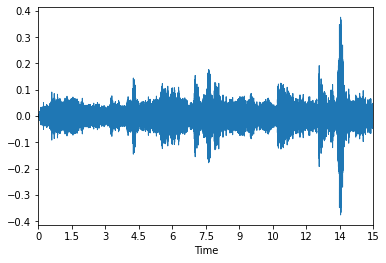

In [ ]:
import librosa.display
y, sr = librosa.load(df_wtnl1.path.values[0],sr=None)
y_half, sr_half = librosa.load(df_wtnl1.path.values[0])

librosa.display.waveplot(y,sr)
#librosa.display.waveplot(y_half, sr_half)
plt.xlim([0,15])
#plt.ylim([-0.2,0.2])



### How different is samples? 

### Adding whitenoise augmentation


In [ ]:
def add_white_noise(signal,noise_factor):
  noise = np.random.normal(0,signal.std(),signal.size)
  augmented_signal = signal + noise * noise_factor
  return augmented_signal

def random_gain(signal, min_gain_factor, max_gain_factor):
  gain_factor = np.random.uniform(min_gain_factor, max_gain_factor)
  return signal * gain_factor


In [ ]:
signal_wtnl1, sr = librosa.load(df_wtnl1.path.values[0], sr=None)
signal_wvl1, sr = librosa.load(df_wvl1.path.values[0], sr=None)


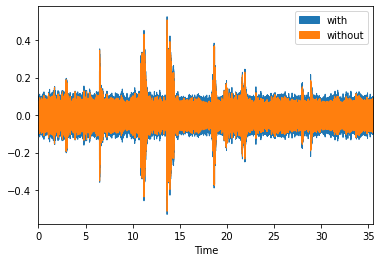

In [ ]:
import librosa.display
y1w = add_white_noise(signal_wvl1,0.5)
librosa.display.waveplot(y1w,sr,label='with')
librosa.display.waveplot(signal_wvl1,sr,label='without')
plt.legend()

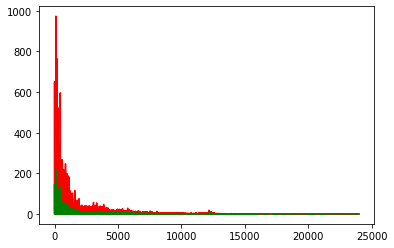

In [ ]:
u1,u2 = plot_fourier(signal_wtnl1, sr)
m1,m2 = plot_fourier(y1w, sr)


plt.plot(m1,m2,label="with whitenoise", c="r")
plt.plot(u1,u2,label="without whitenoise", c="g")

#plt.ylim([0,10])
plt.show()

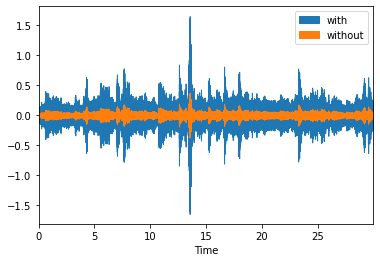

In [ ]:
y1w = random_gain(signal_wtnl1,4,5)
librosa.display.waveplot(y1w,sr,label='with')
librosa.display.waveplot(signal_wtnl1,sr,label='without')
plt.legend()

### Comparing the different leak types in the dataset

In [36]:
from scipy.fft import fft, fftfreq
from scipy.signal import hann
import matplotlib.pyplot as plt
def plot_fourier(signal, sr):
  #n = signal.size
  n = sr*5
  w = hann(n)
  fourier = np.fft.rfft(signal[:n]*w)
  freq = np.fft.rfftfreq(n, d=1./sr)
  return freq, np.abs(fourier)

In [37]:
from scipy.signal import butter, lfilter, filtfilt, sosfilt

def butter_highpass(cutoff, fs, order=9):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=9):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [86]:
df_vent = df_paths.loc[(df_paths['leak_type'] == "ventleak")  & (df_paths['recording'] == 1) & (df_paths['environment'] == 'lab')  & (df_paths['knob_rotations'] == '9.0n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 
df_ventlow = df_paths.loc[(df_paths['leak_type'] == "ventlow")  & (df_paths['recording'] == 1) & (df_paths['environment'] == 'lab')  & (df_paths['knob_rotations'] == '9.0n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 
df_tube = df_paths.loc[(df_paths['leak_type'] == "tubeleak")  & (df_paths['recording'] == 1) & (df_paths['environment'] == 'lab')  & (df_paths['knob_rotations'] == '9.0n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 
 
df_none = df_paths.loc[(df_paths['leak_type'] == "tubeleak")  & (df_paths['recording'] == 1) & (df_paths['environment'] == 'lab')  & (df_paths['knob_rotations'] == '5.0n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 

vent, sr = librosa.load(df_vent.path.values[0], sr=None)
ventlow, sr = librosa.load(df_ventlow.path.values[0], sr=None)
tube, sr = librosa.load(df_tube.path.values[0], sr=None)
none, sr = librosa.load(df_none.path.values[0], sr=None)

df_vent

,path,leak_type,environment,recording,mic,knob_rotations,leak_present
436,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,lab,1,1l,9.0n,1


In [ ]:
from IPython.display import Audio
Audio(df_vent.path.values[0], rate=sr)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Audio(df_tube.path.values[0], rate=sr)

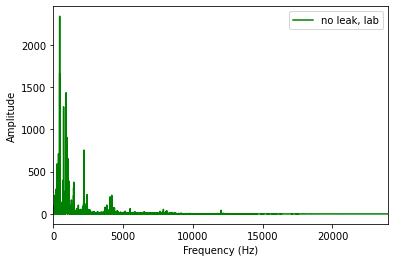

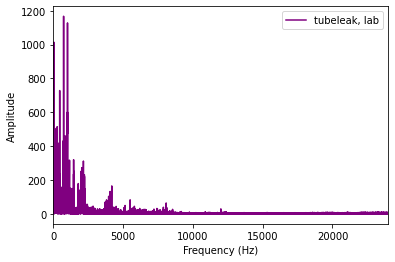

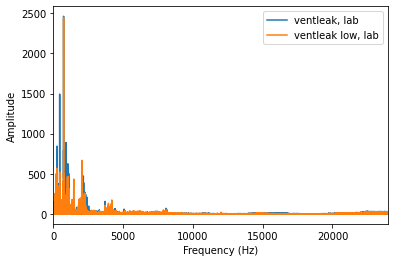

In [ ]:
hp_vent = butter_highpass_filter(vent, 5000, sr,order=9)
hp_ventlow = butter_highpass_filter(ventlow, 5000, sr,order=9)
hp_tube = butter_highpass_filter(tube, 5000, sr,order=9)
hp_none = butter_highpass_filter(none, 5000, sr,order=9)


#v1,v2 = plot_fourier(hp_vent, sr)
#vl1,vl2 = plot_fourier(hp_ventlow, sr)
#t1,t2 = plot_fourier(hp_tube, sr)
#n1,n2 = plot_fourier(hp_none, sr)
v1,v2 = plot_fourier(vent, sr)
vl1,vl2 = plot_fourier(ventlow, sr)
t1,t2 = plot_fourier(tube, sr)
n1,n2 = plot_fourier(none, sr)
#n2 = n2/max(n2)
#v2 = v2/max(v2)
##vl2 = vl2/max(vl2)
#t2 = t2/max(t2)


plt.plot(n1,n2,label="no leak, lab", c="green") 
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim([0,24000])
#plt.ylim([0,50])
plt.legend()
plt.show()

plt.plot(t1,t2,label="tubeleak, lab", c="purple") 
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim([0,24000])
#plt.ylim([0,50])
plt.legend()
plt.show()

plt.plot(v1,v2,label="ventleak, lab") 
plt.plot(vl1,vl2,label="ventleak low, lab")  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim([0,24000])
#plt.ylim([0,50])
plt.legend()
plt.show()

### Plotting feature combinations 

In [53]:
#df_features = get_time_freq_feature_dataframe(df_train, 5)
#df_features1 = get_time_freq_feature_dataframe(df_test, 1)
#df_features5 = get_time_freq_feature_dataframe(df_test, 5)
df_features_5_vent = get_time_freq_feature_dataframe(df_train, 5)

#df_features10 = get_time_freq_feature_dataframe(df_test, 10)
#df_features15 = get_time_freq_feature_dataframe(df_test, 15)
#df_features25 = get_time_freq_feature_dataframe(df_test, 25)


100%|██████████| 48/48 [01:01<00:00,  1.29s/it]


In [ ]:
df_features15 = get_time_freq_feature_dataframe(df_test, 15)
df_features25 = get_time_freq_feature_dataframe(df_test, 25)

In [54]:
#df_1_features = df_features.join(df_train, on="feature_index",how="left")
#df_features_join_1 = df_features1.join(df_test, on="feature_index",how="left")
df_features_join_5 = df_features5.join(df_test, on="feature_index",how="left")
df_features_join_5_vent = df_features_5_vent.join(df_train, on="feature_index",how="left")

#df_features_join_10 = df_features10.join(df_test, on="feature_index",how="left")
#df_features_join_15 = df_features15.join(df_test, on="feature_index",how="left")
#df_features_join_25 = df_features25.join(df_test, on="feature_index",how="left")


In [43]:
#Plotting combinations of the features 
#def plot_features_frames(df_test, frame_len=5):
  #df_features = get_time_freq_feature_dataframe(df_test, frame_len)
  #plot_data = df_features.join(df_test, on="feature_index",how="left")

def plot_features_frames(df_join, df_features):

  #df_plot = df_test_features.loc[:, df_test_features.columns != 'leak_present']

  plot_data = df_join

  names = df_features.columns[1:]

  from sklearn.utils import shuffle
  plot_data = shuffle(plot_data)


  plot_data[df_features.columns.values] = plot_data[df_features.columns.values] / plot_data[df_features.columns.values].max()

  import seaborn as sns

  for name in names:
      #plt.scatter(df_all[names[i[0]]], df_all[[names[i[1]]]], s=200, c=df_all.leak_present, label=)
      #seaborn.relplot(data=plot_data, x=names[i[0]], y=names[i[1]], hue='leak_present', aspect=1)
      sns.relplot(data=plot_data, x=df_features.index.values, y=name, hue="leak_present", style='leak_present', height=5,  aspect=1)

      #plt.legend()
      plt.title(name)
      plt.xlabel("frame")
      plt.show()



In [ ]:
plot_features_frames(df_features_join_1,df_features1)

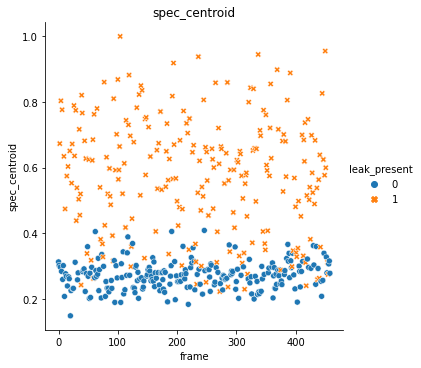

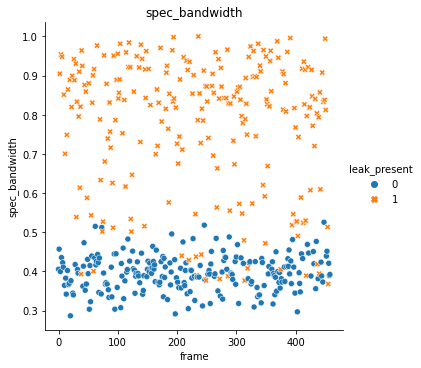

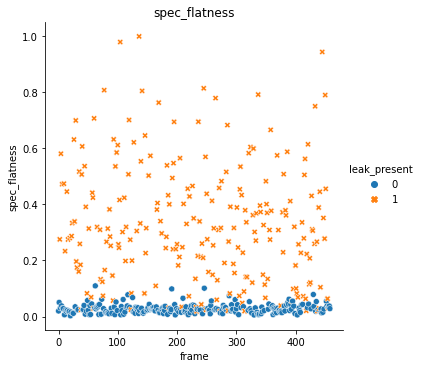

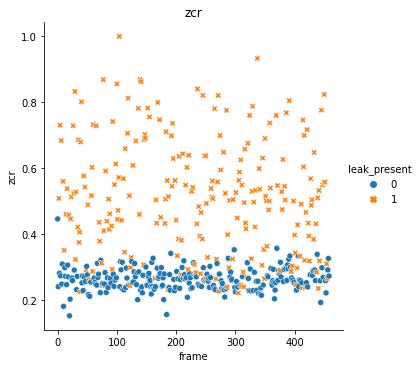

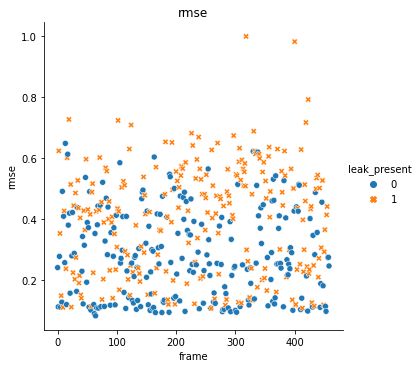

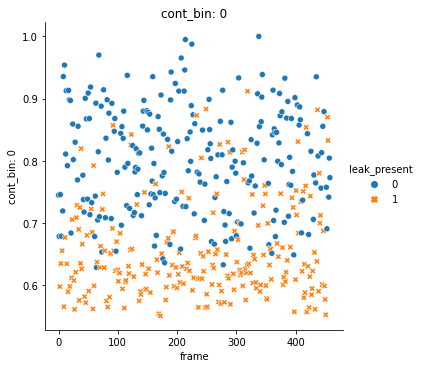

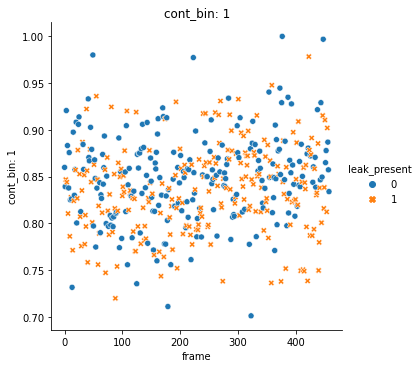

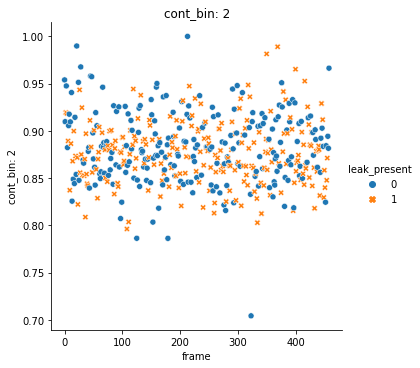

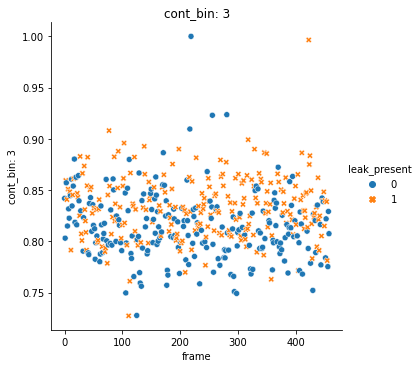

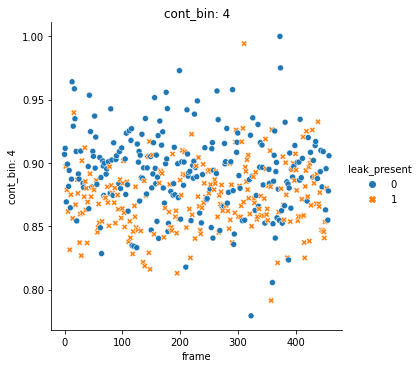

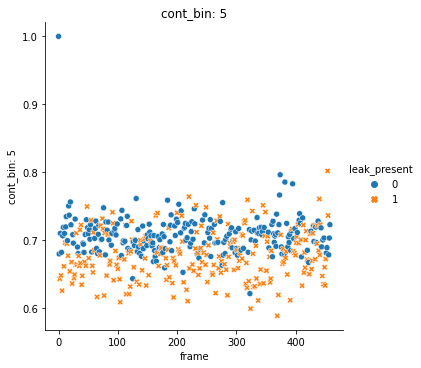

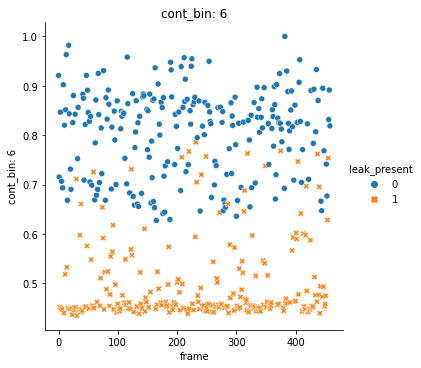

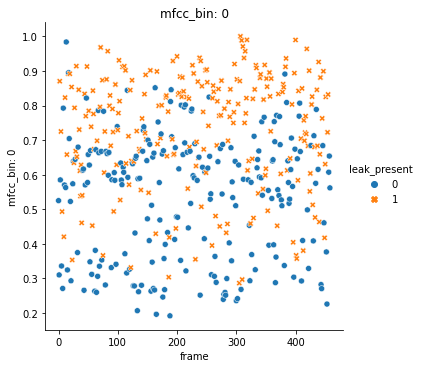

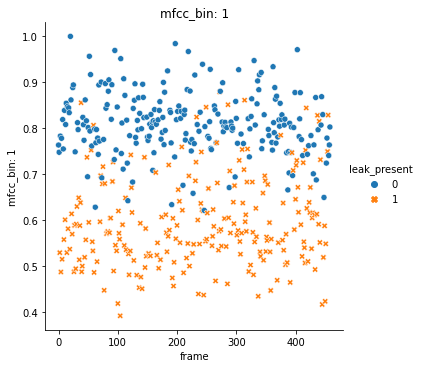

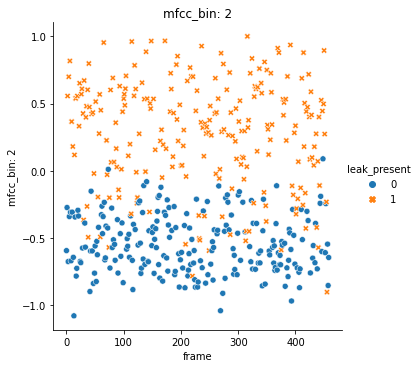

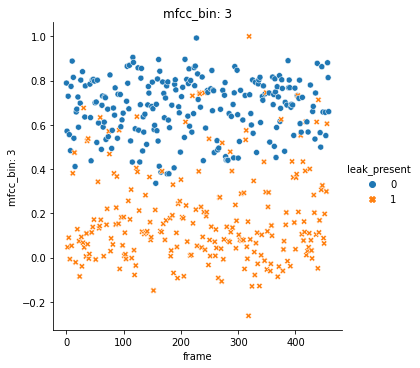

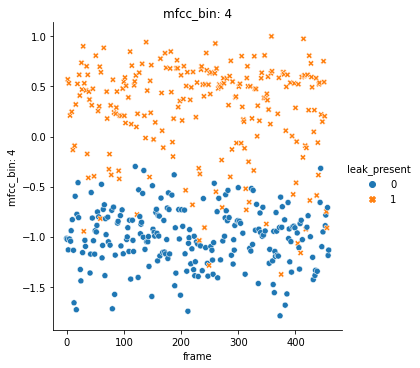

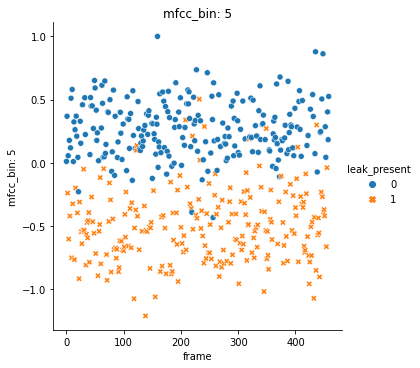

In [50]:
plot_features_frames(df_features_join_5,df_features5) #tube


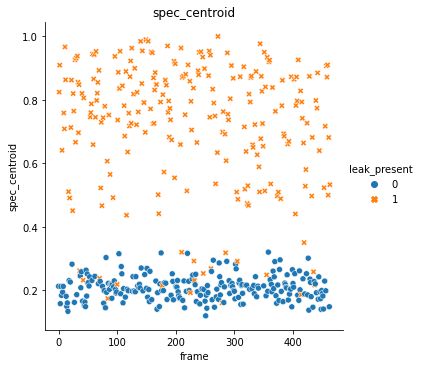

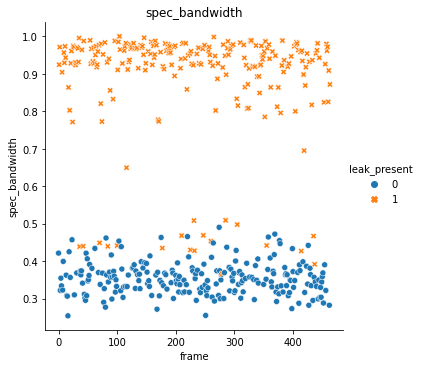

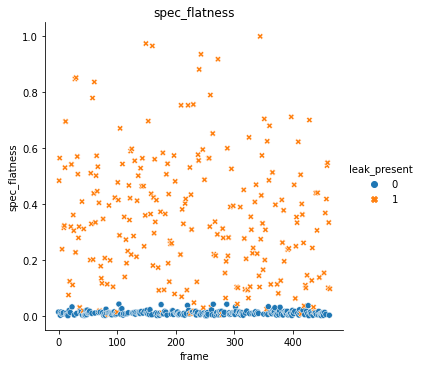

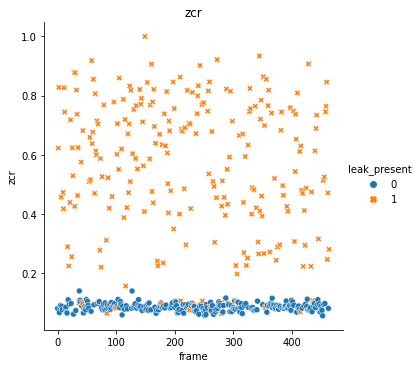

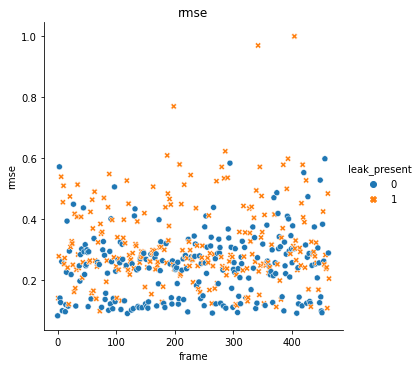

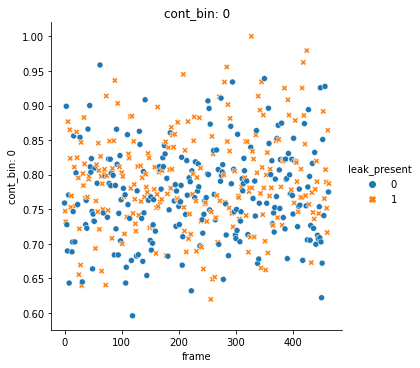

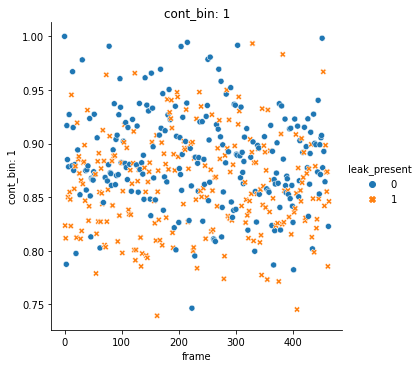

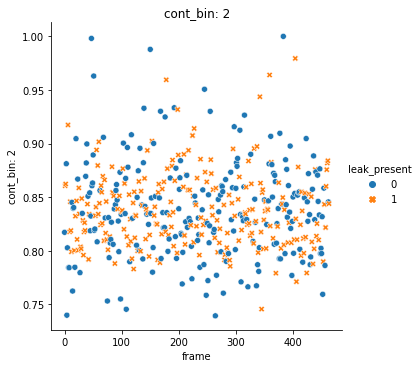

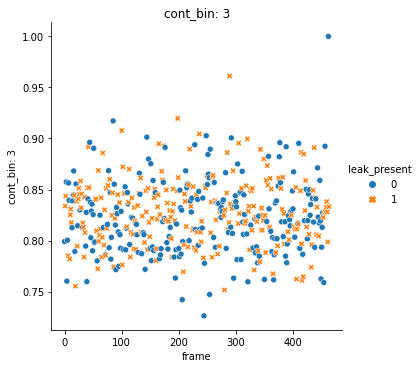

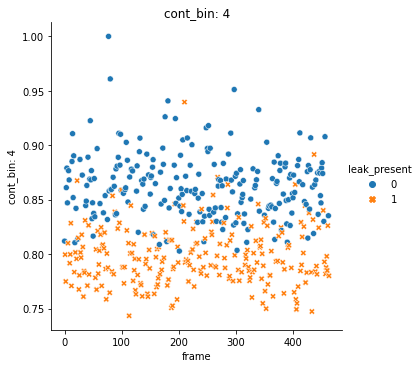

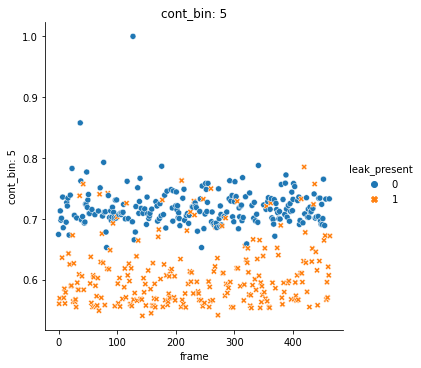

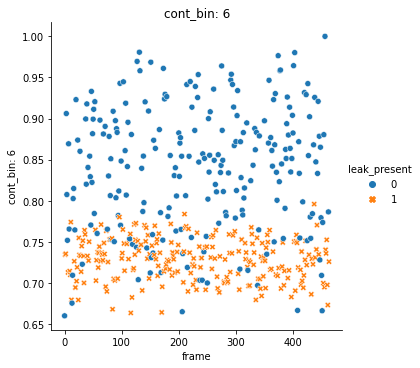

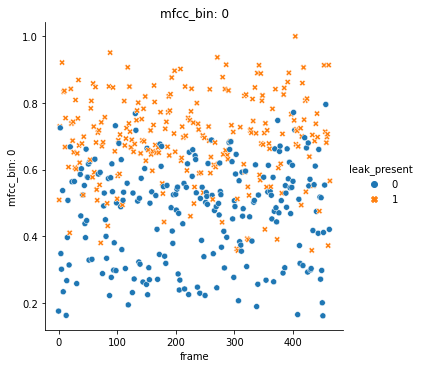

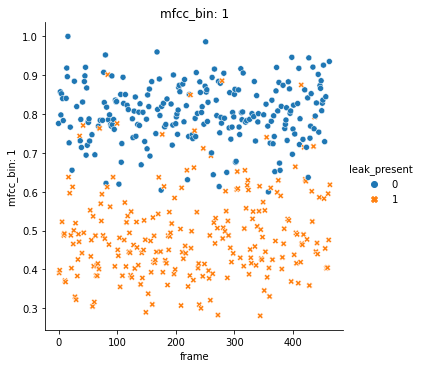

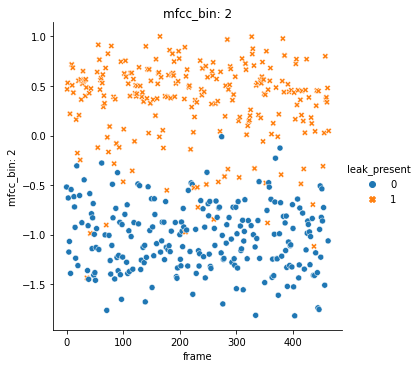

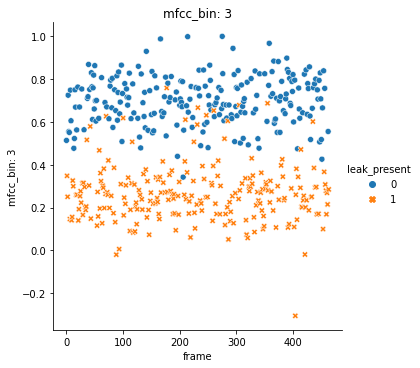

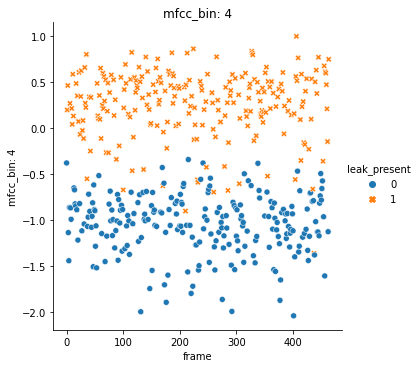

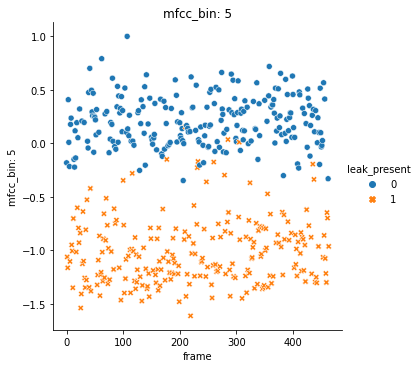

In [55]:
plot_features_frames(df_features_join_5_vent,df_features_5_vent) #vent


In [ ]:
plot_features_frames(df_features_join_10,df_features10)


In [ ]:
plot_features_frames(df_features_join_15,df_features15)

In [ ]:
plot_features_frames(df_features_join_25,df_features25)


### sns pairplot

In [ ]:
df_train_features_subby = df_train_features[["spec_centroid",	"spec_bandwidth",	"spec_flatness","leak_present", "leak_type"]]

In [ ]:
sns.pairplot(df_train_features_subby.select_dtypes(['number']), hue="leak_present")

### Zero-crossing rate

In [ ]:
import librosa.display
files = [tube, vent, none]
for f in files: 
  #Plot the signal:
  plt.figure(figsize=(14, 5))
  librosa.display.waveplot(f, sr=sr)
  # Zooming in
  n0 = 9000
  n1 = 9100
  plt.figure(figsize=(14, 5))
  plt.plot(f[n0:n1])
  plt.grid()

  zero_crossings = librosa.zero_crossings(f, pad=False)
  print(sum(zero_crossings))#16

### Looking at missing values etc. 

In [ ]:
pd.DataFrame(df_paths.groupby(['recording','environment']).leak_type.value_counts())

### File information

In [ ]:
df_file = df_paths.loc[(df_paths['leak_type'] == "ventleak")  & (df_paths['recording'] == 2) & (df_paths['environment'] == 'lab')  & (df_paths['knob_rotations'] == '5.0n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 
import librosa
demo_file, sr = librosa.load(df_file.path.values[0], sr=None)


In [ ]:
librosa.get_duration(demo_file,sr)

In [ ]:
def all_files_dur(): 
  max = 0
  min = 100
  mean = 0
  #seen = 0
  for i,p in tqdm(enumerate(df_paths.path.values)): 
    a, sr = librosa.load(p, sr=None)
    d = librosa.get_duration(a,sr)
    if d > max: 
      max = d
    if d < min: 
      min = d
    mean = (i * mean + d) / (i + 1)



  print(max, min, mean)
  

### Different Noise FFT

In [94]:
hydr_path_m

'/content/gdrive/MyDrive/Masteroppgave/IDMT_dataset/ventleak/hydr/1/1_iO_0.0n_1m_.wav'

In [102]:
df_hydr_vent_m = df_paths.loc[(df_paths['leak_type'] == "ventleak") & (df_paths['environment'] == 'hydr')  & (df_paths['knob_rotations'] == '0.0n') & (df_paths['mic'] == '1m')] #Chosing only some files to reduce load 
df_work_vent_m = df_paths.loc[(df_paths['leak_type'] == "ventleak") & (df_paths['environment'] == 'work')  & (df_paths['knob_rotations'] == '0.0n') & (df_paths['mic'] == '1m')] #Chosing only some files to reduce load 
df_hydr_vent_l = df_paths.loc[(df_paths['leak_type'] == "ventleak") & (df_paths['environment'] == 'hydr')  & (df_paths['knob_rotations'] == '0.0n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 
df_work_vent_l = df_paths.loc[(df_paths['leak_type'] == "ventleak") & (df_paths['environment'] == 'work')  & (df_paths['knob_rotations'] == '0.0n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 

df_work_leak_l = df_paths.loc[(df_paths['leak_type'] == "ventleak") & (df_paths['environment'] == 'work')  & (df_paths['knob_rotations'] == '8.5n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 

work_path_l = df_work_vent_l.path.values[0]
work_path_m = df_work_vent_m.path.values[0]
hydr_path_l = df_hydr_vent_l.path.values[0]
hydr_path_m = df_hydr_vent_m.path.values[0]

y_hydr_vent_l, sr = librosa.load(hydr_path_l, sr=None)
y_hydr_vent_m, sr = librosa.load(hydr_path_m, sr=None)

y_work_vent_m, sr = librosa.load(work_path_m, sr=None)
y_work_vent_l, sr = librosa.load(work_path_l, sr=None)

y_work_leak_l, sr = librosa.load(df_work_leak_l.path.values[0], sr=None)



Text(0.5, 0, 'Frequency (Hz)')

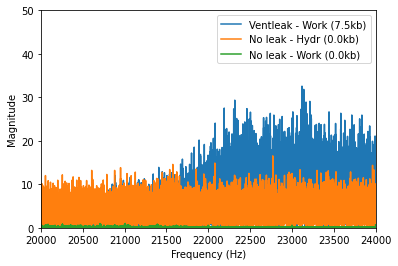

In [111]:
a,b = plot_fourier(y_hydr_vent_m, sr=sr)
al,bl = plot_fourier(y_hydr_vent_l, sr=sr)

c,d = plot_fourier(y_work_vent_m, sr=sr)
cl,dl = plot_fourier(y_work_vent_l, sr=sr)

x, x1  = plot_fourier(y_work_leak_l, sr=sr)

"""b = b/b.max()
bl = bl/bl.max()
d = d/d.max()
dl = dl/dl.max()

x1= x1/x1.max()
"""
plt.plot(x,x1, label="Ventleak - Work (7.5kb)")# - l")#, color=blu)
plt.plot(a,b, label="No leak - Hydr (0.0kb)")# - m")#, color=blu)
plt.plot(c,d, label="No leak - Work (0.0kb)")# - m")#, color=blu)
#plt.plot(cl,dl, label="No leak - Work (0.0kb) - l ")#, color=blu)
#plt.plot(al,bl, label="Hydr - l")#, color=blu)


#plt.ylim([0,0.001])
plt.ylim([0,50])
plt.xlim([20000,24000])
plt.legend()
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")
#plt.title("Frequency spectrum of two different environments")

### Recording sound difference

In [ ]:
df_work = df_paths.loc[(df_paths['leak_type'] == "ventleak") & (df_paths['environment'] == 'hydr')  & (df_paths['knob_rotations'] == '7.5n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 
df_work

,path,leak_type,environment,recording,mic,knob_rotations,leak_present
75,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,hydr,1,1l,7.5n,1
220,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,hydr,2,1l,7.5n,1
334,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,hydr,3,1l,7.5n,1


In [ ]:
w = []
for work in df_work.path.values: 
  w.append(librosa.load(work, sr=None)[0])
w

[array([ 0.0000000e+00, -1.5377998e-04, -4.1365623e-05, ...,
         9.3793869e-04,  2.8574467e-04,  1.8501282e-04], dtype=float32),
 array([ 0.0000000e+00, -6.5636635e-04, -1.0956526e-03, ...,
         7.3552132e-05, -1.5497208e-04, -5.5313110e-05], dtype=float32),
 array([ 0.0000000e+00, -3.2591820e-04, -7.0559978e-04, ...,
         2.9993057e-04, -9.3936920e-05, -1.0275841e-04], dtype=float32)]

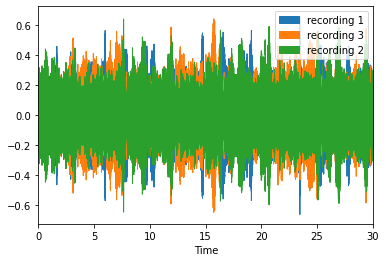

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

librosa.display.waveplot(w[2],sr=48000, label="recording 1")
librosa.display.waveplot(w[0],sr=48000, label="recording 3")
librosa.display.waveplot(w[1],sr=48000, label="recording 2")
plt.legend()

Text(0.5, 1.0, 'ventleak, hydr, mic 1 during leak')

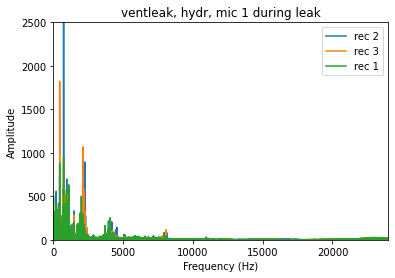

In [ ]:
m1x,m1y = plot_fourier(w[2], sr=48000)
m2x,m2y = plot_fourier(w[0], sr=48000)
m3x,m3y = plot_fourier(w[1], sr=48000)

plt.plot(m2x,m2y, label="rec 2")
plt.plot(m3x,m3y, label="rec 3" )#, color=oran)
plt.plot(m1x,m1y, label="rec 1")#, color=blu)
plt.ylim([0,2500])
plt.xlim([0,24000])
plt.legend()
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.title("ventleak, hydr, mic 1 during leak")

### Endring i freq. ved økt knob_rotations

In [ ]:
df_kb = df_paths.loc[(df_paths['leak_type'] == "ventleak") & (df_paths['recording'] == 2) & (df_paths['environment'] == 'work') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 
df_kb_sort = df_kb.sort_values("knob_rotations")
df_kb_sort

### Difference between leak and no leak

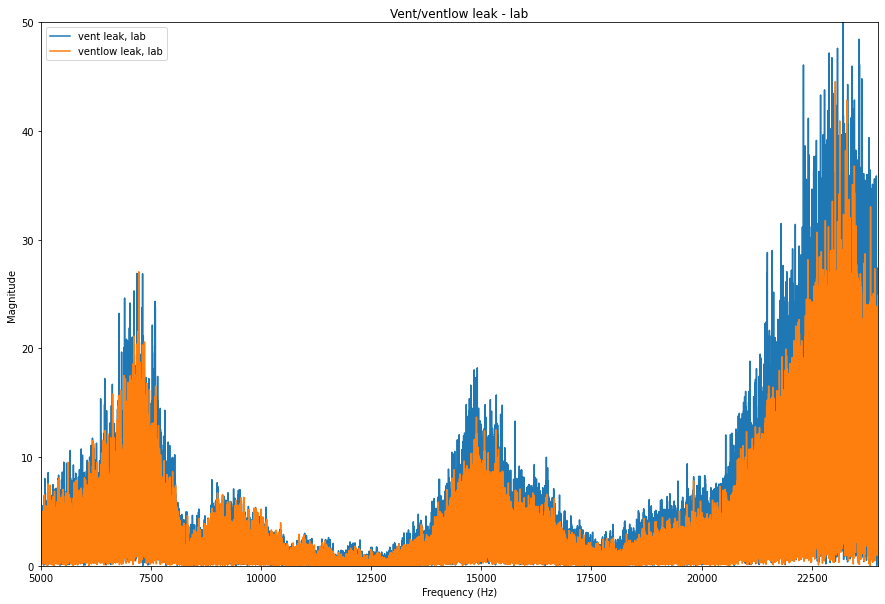

In [88]:
v1,v2 = plot_fourier(vent, sr)
n1,n2 = plot_fourier(none, sr)
t1,t2 = plot_fourier(tube, sr)
vl1,vl2 = plot_fourier(ventlow, sr)


#plt.plot(v1,v2,label="leak, lab", c="red")
#plt.plot(n1,n2,label="no leak, lab", c="green")
 

n2_dB = 20*np.log10(n2)
v2_dB = 20*np.log10(v2)
t2_dB = 20*np.log10(t2)


plt.figure(figsize=(15,10))
#plt.plot(n1,n2_dB,label="no leak, work", c="green")
#plt.plot(t1,t2_dB,label="tube leak, work", c="purple")
#plt.plot(v1,v2_dB,label="vent leak, work", c="red")

##plt.plot(n1,n2,label="no leak, work", c="green")
#plt.plot(t1,t2,label="tube leak, work", c="purple")
plt.plot(v1,v2,label="vent leak, lab")
plt.plot(vl1,vl2,label="ventlow leak, lab")



plt.title("Vent/ventlow leak - lab")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")# (dB)")
#plt.yscale('log')
plt.xlim([5000,24000])
plt.ylim([0,50])

plt.legend()
plt.show()

### FFT of different mics

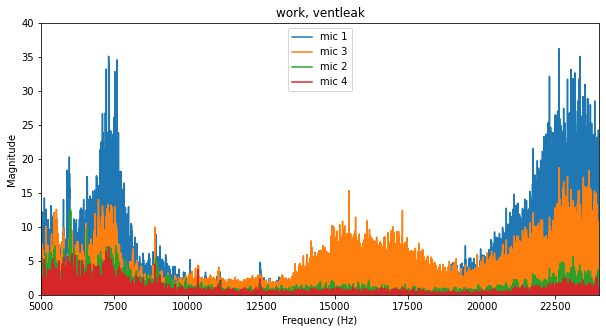

In [93]:
leak = "tubeleak"
leak = "ventleak"
env = "work"
environments = ["lab", "work", "hydr"]
environments = ["work"]
kb = '9.0n'
knob_ros = ['9.0n']
for env in environments: 
  for kb in knob_ros: 
    df_mics = df_paths.loc[(df_paths['leak_type'] == leak) & (df_paths['recording'] == 3) & (df_paths['environment'] == env)  & (df_paths['knob_rotations'] == kb)] #Chosing only some files to reduce load 

    m1,sr = librosa.load(df_mics.loc[(df_mics['mic'] == '1l')].path.values[0], sr=None)
    m2,sr = librosa.load(df_mics.loc[(df_mics['mic'] == '2l')].path.values[0], sr=None)
    m3,sr = librosa.load(df_mics.loc[(df_mics['mic'] == '3l')].path.values[0], sr=None)
    m4,sr = librosa.load(df_mics.loc[(df_mics['mic'] == '4l')].path.values[0], sr=None)


    m1x,m1y = plot_fourier(m1, sr)
    m2x,m2y = plot_fourier(m2, sr)
    m3x,m3y = plot_fourier(m3, sr)
    m4x,m4y = plot_fourier(m4, sr)


    plt.figure(figsize=(10,5))
    import matplotlib.colors as mcolors
    blu = mcolors.TABLEAU_COLORS['tab:blue']
    oran = mcolors.TABLEAU_COLORS['tab:orange']
    redd = mcolors.TABLEAU_COLORS['tab:red']
    gren = mcolors.TABLEAU_COLORS['tab:green']




    plt.plot(m1x,m1y, label="mic 1", color=blu)
    plt.plot(m3x,m3y, label="mic 3", color=oran)
    plt.plot(m2x,m2y, label="mic 2", color=gren)
    plt.plot(m4x,m4y, label="mic 4", color=redd)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")

    plt.xlim([5000,24000])
    plt.ylim([0,40])

    plt.title(env + ", " + leak)# + " ("+kb+")")
    plt.legend()
    plt.show()


Below is a plot where I observe that above 12kHz aprox. there is very little difference between the environemts. My theory however was that they were completly equal above that freq. and we only had "lab" that wasnt played from a speaker, but there is still some difference. 

In [ ]:
leak = "ventleak"
leak = "tubeleak"
env = "work"
environments = ["hydr","work","lab"]
kb = '0.0n'
knob_ros = ['0.0n','9.0n']
plt.figure(figsize=(10,5))
mics = ['1l','2l','3l','4l']

for mic in mics: 
  for env in environments: 
    #for kb in knob_ros: 
    df_mics = df_paths.loc[(df_paths['leak_type'] == leak) & (df_paths['recording'] == 3) & (df_paths['environment'] == env)  & (df_paths['knob_rotations'] == kb)] #Chosing only some files to reduce load 

    m1,sr = librosa.load(df_mics.loc[(df_mics['mic'] == mic)].path.values[0], sr=None)
    #m2,sr = librosa.load(df_mics.loc[(df_mics['mic'] == '2l')].path.values[0], sr=None)
    #m3,sr = librosa.load(df_mics.loc[(df_mics['mic'] == '3l')].path.values[0], sr=None)
    #m4,sr = librosa.load(df_mics.loc[(df_mics['mic'] == '4l')].path.values[0], sr=None)


    m1x,m1y = plot_fourier(m1, sr)
    m2x,m2y = plot_fourier(m2, sr)
    m3x,m3y = plot_fourier(m3, sr)
    m4x,m4y = plot_fourier(m4, sr)


    import matplotlib.colors as mcolors
    blu = mcolors.TABLEAU_COLORS['tab:blue']
    oran = mcolors.TABLEAU_COLORS['tab:orange']
    redd = mcolors.TABLEAU_COLORS['tab:red']
    gren = mcolors.TABLEAU_COLORS['tab:green']




    plt.plot(m1x,m1y, label=env)#, color=blu)
    #plt.plot(m3x,m3y, label=env )#, color=oran)
    #plt.plot(m2x,m2y, label="mic 2", color=gren)
    #plt.plot(m4x,m4y, label="mic 4", color=redd)

    #plt.show()
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Amplitude")

  plt.xlim([12000,24000])
  plt.ylim([0,10])

  #plt.title(env + ", " + leak + " ("+kb+")")
  plt.title(leak + " ("+kb+")" +  ", mic " + mic)

  plt.legend()
  plt.show()

### Plotting relative power feautre

In [ ]:
df_no_leak = df_paths.loc[(df_paths['leak_type'] == "ventleak")  & (df_paths['recording'] == 2) & (df_paths['environment'] == 'hydr')  & (df_paths['knob_rotations'] == '5.0n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 
df_leak = df_paths.loc[(df_paths['leak_type'] == "ventleak")  & (df_paths['recording'] == 2) & (df_paths['environment'] == 'hydr')  & (df_paths['knob_rotations'] == '5.5n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 

nl,sr = librosa.load(df_no_leak.path.values[0], sr=None)
l,sr = librosa.load(df_leak.path.values[0], sr=None)

df_no_leak

,path,leak_type,environment,recording,mic,knob_rotations,leak_present
208,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,hydr,2,1l,5.0n,0


Text(0.5, 1.0, 'ventleak, hydr')

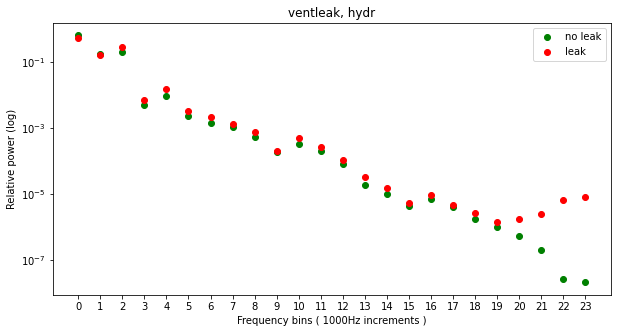

In [ ]:
band_list = make_list([0,24000,1000])

b = bandpower(nl,sr,band_list,relative=True)
c = bandpower(l,sr,band_list,relative=True)

bt = b.T
ct = c.T

x_ax = np.arange(0,len(bt.index),1)
plt.figure(figsize=(10,5)) 

plt.scatter(x_ax,bt.iloc[:,0],c="g",label="no leak")
plt.scatter(x_ax,ct.iloc[:,0],c="r",label="leak")

#plt.title("Comparing power in frequency bins to total power")
plt.xlabel("Frequency bins" + " ( " +str(1000)+"Hz increments )"  )
plt.xticks(x_ax)
plt.yscale('log')
plt.ylabel("Relative power (log)")
plt.legend()
plt.title("ventleak, hydr")

Text(0.5, 1.0, 'ventleak, hydr')

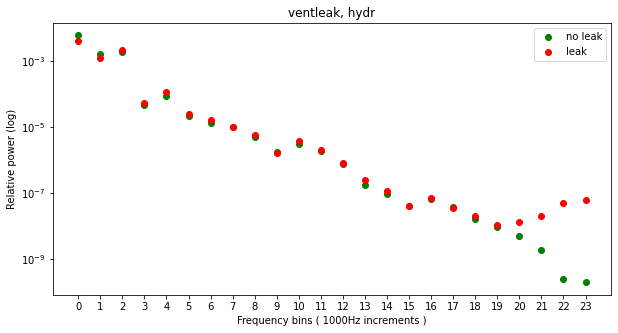

In [ ]:
band_list = make_list([0,24000,1000])

b = bandpower(nl,sr,band_list,relative=False)
c = bandpower(l,sr,band_list,relative=False)

bt = b.T
ct = c.T

x_ax = np.arange(0,len(bt.index),1)
plt.figure(figsize=(10,5)) 

plt.scatter(x_ax,bt.iloc[:,0],c="g",label="no leak")
plt.scatter(x_ax,ct.iloc[:,0],c="r",label="leak")

#plt.title("Comparing power in frequency bins to total power")
plt.xlabel("Frequency bins" + " ( " +str(1000)+"Hz increments )"  )
plt.xticks(x_ax)
plt.yscale('log')
plt.ylabel("Relative power (log)")
plt.legend()
plt.title("ventleak, hydr")

### Plotting several plots


In [ ]:

def plot_all(signal_name, waveform=True, power_spectrum=False, spectrogram=False, mfcc=False, pdf_name=None):
  FIG_SIZE = (30,10)

  n = len(signal_name)

  #fig = plt.figure()
  fig = plt.figure(figsize=FIG_SIZE)
  fig.subplots_adjust(hspace=1.0, wspace=1.0)


  if waveform:
    for i in range(n): 
      # load audio file with Librosa
      signal, sample_rate = librosa.load(signal_name[i], sr=None)
      ax = fig.add_subplot(4,n,int(i+1), ylabel="Amplitude", title="Waveform")
      
      if "_niO_" in signal_name[i]:
        ax.set_title(str(i) + ": leak")
      else:
        ax.set_title(str(i) + ": no leak")


      #plt.subplot()
      #plt.figure(figsize=FIG_SIZE)
      librosa.display.waveplot(signal, sample_rate, alpha=0.4)
      #ax.xlabel("Time (s)")
      #ax.ylabel("Amplitude")
      #ax.title("Waveform")
    #fig.show()

  if power_spectrum:

    for i in range(n): 

      # load audio file with Librosa
      signal, sample_rate = librosa.load(signal_name[i], sr=None)
      #plt.subplot(1,n,int(i+1))
      i = n + i 
      ax = fig.add_subplot(4,n,int(i+1), xlabel = "Frequency", ylabel="Magnitude", title="Power spectrum")


      # FFT -> power spectrum
      # perform Fourier transform
      fft = np.fft.fft(signal)

      # calculate abs values on complex numbers to get magnitude
      spectrum = np.abs(fft)

      # create frequency variable
      f = np.linspace(0, sample_rate, len(spectrum))

      # take half of the spectrum and frequency
      left_spectrum = spectrum[:int(len(spectrum)/2)]
      left_f = f[:int(len(spectrum)/2)]

      # plot spectrum
      ax.plot(left_f, left_spectrum, alpha=0.4)
      #plt.xlabel("Frequency")
      #plt.ylabel("Magnitude")
      #plt.title("Power spectrum")
  #plt.show()


  if spectrogram:

    for i in range(n): 
      # load audio file with Librosa
      signal, sample_rate = librosa.load(signal_name[i], sr=None)
      #plt.subplot(1,n,int(i+1))
      i = 2*n + i 

      ax = fig.add_subplot(4,n,int(i+1), xlabel = "Time", ylabel="Frequency", title="Spectrogram (dB)")

      # STFT -> spectrogram
      hop_length = int(sample_rate*0.3) # in num. of samples
      n_fft = int(hop_length//2) # window in num. of samples

      # calculate duration hop length and window in seconds
      hop_length_duration = float(hop_length)/sample_rate
      n_fft_duration = float(n_fft)/sample_rate

      # perform stft
      stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

      # calculate abs values on complex numbers to get magnitude
      spectrogram = np.abs(stft)

      # apply logarithm to cast amplitude to Decibels
      log_spectrogram = librosa.amplitude_to_db(spectrogram)

      librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
      plt.xlabel("Time")
      plt.ylabel("Frequency")
      plt.colorbar(format="%+2.0f dB")
      plt.title("Spectrogram (dB)")
    #fig.show()


  if mfcc:

    for i in range(n): 
      # load audio file with Librosa
      signal, sample_rate = librosa.load(signal_name[i], sr=None)
      #plt.subplot(1,n,int(i+1))  
      i = 3*n + i 
      ax = fig.add_subplot(4,n,int(i+1), xlabel = "Time", ylabel="MFCC coefficients", title="MFCCs")
  
      # MFCCs
      # extract 13 MFCCs
      MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

      # display MFCCs
      librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
      plt.xlabel("Time")
      plt.ylabel("MFCC coefficients")
      plt.colorbar()
      plt.title("MFCCs")

  # show plots
  #fig.show()
  if pdf_name:
    plt.savefig(pdf_name)  


#one_of_both = [no_lekk_files[0],lekk_files[0]]

#plot_all(one_of_both, waveform=True, power_spectrum=True, spectrogram=True, mfcc=True, pdf_name="one_of_both.pdf")
#plot_all(all_files, waveform=True, power_spectrum=True, spectrogram=True, mfcc=True, pdf_name="all_leaks.pdf")


In [ ]:
import librosa.display

plot_all(df_file.path.values[:3], waveform=True, power_spectrum=True, spectrogram=True, mfcc=True, pdf_name=None)

In [ ]:
df_file = df_paths.loc[(df_paths['leak_type'] == "ventleak")  & (df_paths['recording'] == 2) & (df_paths['knob_rotations'] == '5.0n') & (df_paths['mic'] == '1l')] #Chosing only some files to reduce load 
df_file.path.values[:3]

### CV figure


In [ ]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )
    """
    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    """
    yticklabels = list(range(n_splits))# + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.2],
        xlim=[0, 100],
    )
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    GroupShuffleSplit,
    GroupKFold,
    StratifiedShuffleSplit,
    StratifiedGroupKFold,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

np.random.seed(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

In [ ]:
# Generate the class/group data

n_points = 100
X = np.random.randn(100, 10)

percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

groups = np.hstack([[ii] * 10 for ii in range(10)])
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

### Plotting potential outliers

In [39]:
path_out = df_paths.iloc[263].path
#from IPython.display import Audio
#Audio(path_out, rate=48000)



In [40]:
path_out

'/content/gdrive/MyDrive/Masteroppgave/IDMT_dataset/ventleak/hydr/3/3_iO_4.5n_1m_.wav'

In [45]:
path_out_r2 = '/content/gdrive/MyDrive/Masteroppgave/IDMT_dataset/ventleak/hydr/2/2_niO_5.5n_1m_.wav'


In [42]:
path_inn = df_paths.iloc[310].path
#from IPython.display import Audio
#Audio(path_inn, rate=48000)


In [57]:
path_inn

'/content/gdrive/MyDrive/Masteroppgave/IDMT_dataset/ventleak/hydr/3/3_iO_4.5n_1l_.wav'

In [43]:
df_paths.iloc[343].path

'/content/gdrive/MyDrive/Masteroppgave/IDMT_dataset/ventleak/hydr/3/3_niO_5.5n_1m_.wav'

In [124]:

path_aleak_m = df_paths.iloc[343].path
path_aleak_l = '/content/gdrive/MyDrive/Masteroppgave/IDMT_dataset/ventleak/hydr/3/3_niO_5.5n_1l_.wav'

#from IPython.display import Audio
#Audio(path_aleak, rate=48000)
path_aleak_m

'/content/gdrive/MyDrive/Masteroppgave/IDMT_dataset/ventleak/hydr/3/3_niO_5.5n_1m_.wav'

In [46]:
out, sr = librosa.load(path_out, sr=None)
outr2, sr = librosa.load(path_out_r2, sr=None)

inn, sr = librosa.load(path_inn, sr=None)
leak_m, sr = librosa.load(path_aleak_m, sr=None)
leak_l, sr = librosa.load(path_aleak_l, sr=None)

Text(0.5, 1.0, 'ventleak, hydr, mic 1 during leak')

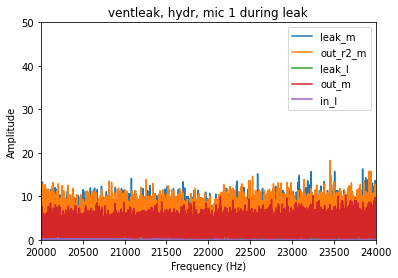

In [49]:


outx,outy = plot_fourier(out, sr=sr)
outxr2,outyr2 = plot_fourier(outr2, sr=sr)

innx,inny = plot_fourier(inn, sr=sr)
leakx, leaky = plot_fourier(leak_m, sr=sr)
leaklx, leakly = plot_fourier(leak_l, sr=sr)




plt.plot(leakx, leaky, label="leak_m")
plt.plot(outxr2,outyr2, label="out_r2_m")
plt.plot(leaklx, leakly, label="leak_l")
plt.plot(outx,outy, label="out_m")
plt.plot(innx,inny, label="in_l")

plt.ylim([0,50])
plt.xlim([20000,24000])
plt.legend()
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.title("ventleak, hydr, mic 1 during leak")

0
1
2
inside!
0
1
2
inside!
0
1
2
inside!
0
1
2
inside!


Text(0.5, 1.0, 'ventleak, hydr')

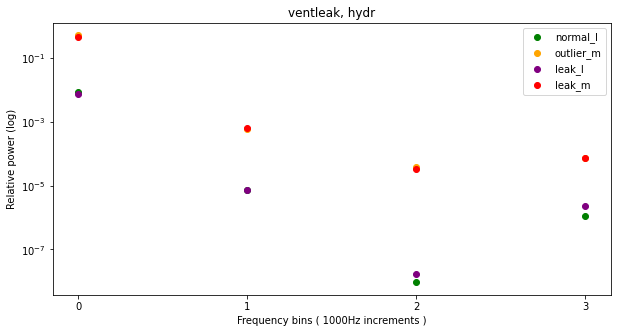

In [123]:
#band_list = make_list([0,24000,1000])
band_list = [0,10000,20000,24000]

b = bandpower2(out,sr,band_list,relative=False)
c = bandpower2(inn,sr,band_list,relative=False)
d = bandpower2(leak_m,sr,band_list,relative=False)
e = bandpower2(leak_l,sr,band_list,relative=False)



outlier = b.T
normal = c.T
b_leak_m = d.T
b_leak_l = e.T


x_ax = np.arange(0,len(outlier.index),1)
plt.figure(figsize=(10,5)) 

plt.scatter(x_ax,normal.iloc[:,0],c="g",label="normal_l")
plt.scatter(x_ax,outlier.iloc[:,0],c="orange",label="outlier_m")
plt.scatter(x_ax,b_leak_l.iloc[:,0],c="purple",label="leak_l")
plt.scatter(x_ax,b_leak_m.iloc[:,0],c="r",label="leak_m")


#plt.title("Comparing power in frequency bins to total power")
plt.xlabel("Frequency bins" + " ( " +str(1000)+"Hz increments )"  )
plt.xticks(x_ax)
plt.yscale('log')
#plt.ylim([0,0.001])
plt.ylabel("Relative power (log)")
plt.legend()
plt.title("ventleak, hydr")

In [75]:
df = pd.concat([outlier,normal,b_leak_m,b_leak_l],axis=1)
df.columns = ["outlier_m", "normal_l", "leak_m", "leak_l"]
df = np.log(df)
df

,outlier_m,normal_l,leak_m,leak_l
0,-0.001293,-0.000820,-0.001504,-0.001025
1,-6.710220,-7.107787,-6.551566,-6.885760
2,-9.509379,-13.732996,-9.504359,-12.968441


In [121]:
def bandpower2(data, sf, band_list, window_sec=None, relative=False, reduce_split=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """


    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = 0.3 * sf

    # Compute the modified periodogram (Welch)
    #win = scipy.signal.get_window('hanning',nperseg)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    
    avg_band_power = []

    #Kan vurdere å bruke matplotlib sin psd 
    ##win = matplotlib.mlab.window_hanning(np.ones(nperseg)) # or
    ##psd, freqs = matplotlib.mlab.psd(data, Fs=sf,window=win)



    # Frequency resolution
    for i in range(len(band_list)-1):
      print(i)
      freq_res = freqs[1] - freqs[0]
      low = band_list[i]
      high = band_list[i+1]

      # Find closest indices of band in frequency vector
      idx_band = np.logical_and(freqs >= low, freqs <= high)

      # Integral approximation of the spectrum using Simpson's rule.
      bp = simps(psd[idx_band], dx=freq_res)


      if relative:
          bp /= simps(psd, dx=freq_res)

      avg_band_power.append(bp)


      if not relative and i == 2: #final one
        print("inside!")
        bp /= simps(psd, dx=freq_res)
        avg_band_power.append(bp)




    if reduce_split:
      reduced = []  
      for i in range(len(reduce_split)-1):
        s = avg_band_power[reduce_split[i]:reduce_split[i+1]]
        reduced.append(sum(s))
      return pd.DataFrame([reduced])

    return pd.DataFrame([avg_band_power])

0
1
2
inside!


Text(0.5, 1.0, 'ventleak, hydr')

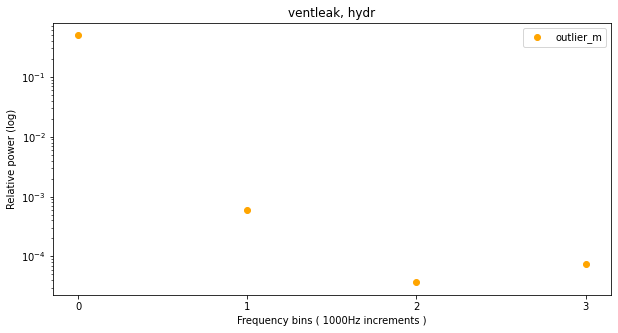

In [122]:
#band_list = make_list([0,24000,1000])
band_list = [0,10000,20000,24000]

b = bandpower2(out,sr,band_list,relative=False)




outlier = b.T


x_ax = np.arange(0,len(outlier.index),1)
plt.figure(figsize=(10,5)) 

plt.scatter(x_ax,outlier.iloc[:,0],c="orange",label="outlier_m")



#plt.title("Comparing power in frequency bins to total power")
plt.xlabel("Frequency bins" + " ( " +str(1000)+"Hz increments )"  )
plt.xticks(x_ax)
plt.yscale('log')
#plt.ylim([0,0.001])
plt.ylabel("Relative power (log)")
plt.legend()
plt.title("ventleak, hydr")